# Multiple enemies

Now we will increase the number of enemies to $3$

In [1]:
import torch
from IPython.core.display import display
from torch.optim import Adam

from environments import VariablePendulumJIT
from evaluators.direct_actor import ActorVariable
from helpers import *
from renderer import render_variable_enemies
from utils import MLP, TrainUntil

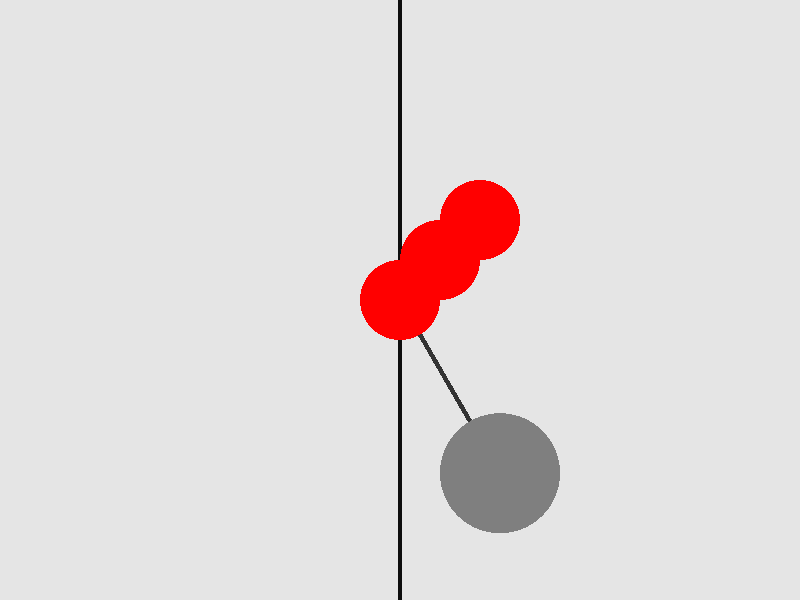

In [2]:
state = create_state_variable(np.array([1, 1, 2, 2, 0, 0], dtype=np.float32))
render_variable_enemies(np.array([0.1, 0.1, 0.2, 0.2, 0, 0], dtype=np.float32))

Train difficulty evaluator from the oracle, as previously.
However, now we'll have the $x \in [-1, 1]$ amd $y \in [-1, 2]$ parameters of three enemies.
This creates a 6-dimensional space, that is infeasible to evaluate directly.

We will still sample environment randomly for several iterations, to bootstrap our evaluator
with the predictions from the oracle. Later, however, we should also evaluate the generated
levels with the oracle and update our level difficulty evaluator once per several iterations.

In [3]:
num_enemies = 3

mins = np.array([enemy_x_min, enemy_y_min] * num_enemies, dtype=np.float32)
maxs = np.array([enemy_x_max, enemy_y_max] * num_enemies, dtype=np.float32)

mins_t = torch.from_numpy(mins)
maxs_t = torch.from_numpy(maxs)

diff = maxs - mins

state_size = state_size_fixed + num_enemies * 2

@njit
def generate_embedding(batch_size):
    enemies = np.random.uniform(0, 1, (batch_size, num_enemies * 2)).astype(np.float32)
    enemies = enemies * (maxs - mins) + mins
    return enemies

@njit(parallel=True)
def embedding2states(embedding):
    states = np.zeros((embedding.shape[0], state_size), dtype=np.float32)
    for i in prange(embedding.shape[0]):
        e = embedding[i]
        states[i] = create_state_variable(e)

    return states


env = VariablePendulumJIT(3)
actors, weights = create_actors(25, actor_class=ActorVariable)
oracle = TrajectoryRewardsEvaluator(env, actors, weights, num_evaluations, max_trajectory_length)

In [4]:
evaluator = MLP(num_enemies * 2, 1, [4, 6, 8, 6, 4], activation="lrelu")
optim_evaluator = Adam(evaluator.parameters(), lr=0.01)

batch_size=50

with TrainUntil(1e-4, 50, 10000, print_frequency=10, clear=True) as trainer:
    while not trainer.done:
        embedding = generate_embedding(batch_size)
        states = embedding2states(embedding).reshape((batch_size, 1, state_size))
        target = torch.from_numpy(oracle.evaluate(states)).squeeze(-1)

        predicted = evaluator(torch.from_numpy(embedding))
        loss = ((predicted - target) ** 2).mean()

        optim_evaluator.zero_grad()
        loss.backward()
        optim_evaluator.step()

        trainer.loss = loss


Done after 161 iteration(s). Loss: 0.000030


Once trained evaluator, train the generator, as before

In [8]:
generator = MLP(1, 2 * num_enemies, [4, 8, 8])
optim_generator = Adam(generator.parameters(), lr=0.001)

batch_size = 100

def clamp(states):
    clamped = torch.where(states < mins_t, mins_t, states)
    clamped = torch.where(clamped > maxs_t, maxs_t, clamped)
    return clamped


with TrainUntil(0.01, 100, 10000, print_frequency=50, clear=True) as trainer:
    while not trainer.done:
        d_in = torch.rand([batch_size, 1])
        embedding = generator(d_in)
        clamped = clamp(embedding)
        clamp_loss = ((clamped - embedding) ** 2).mean()

        d_out = evaluator(embedding)

        difficulty_loss = (d_in - d_out).abs().mean()

        loss = difficulty_loss + clamp_loss

        optim_generator.zero_grad()
        loss.backward()
        optim_generator.step()

        trainer.loss = loss

Done after 10001 iteration(s). Loss: 0.456270


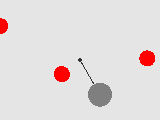

0.0

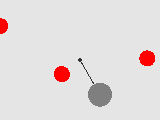

0.1111111119389534

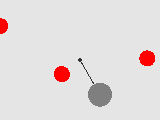

0.2222222238779068

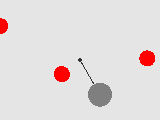

0.3333333432674408

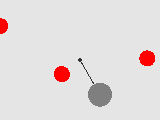

0.4444444477558136

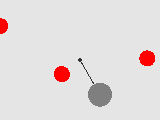

0.5555555820465088

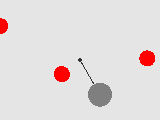

0.6666666269302368

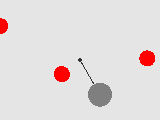

0.7777777910232544

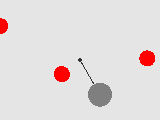

0.8888888955116272

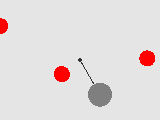

1.0

In [9]:
d_in = torch.linspace(0, 1, 10).unsqueeze(1)

with torch.no_grad():
    embeddings = clamp(generator(d_in))

images = [render_variable_enemies(e.numpy(), resolution=0.2) for e in embeddings]

for image, d in zip(images, d_in):
    display(image)
    display(d.item())